## Set up env

### Load modules

Apart from some standard libraries, we'll be using pysam to genotype the transposon based on the occurence of soft-clipped reads that overlap the insertion site in the BAMs and the Manhattan plotting function from limix (the association analyses themselves are done with gemma)

In [1]:
import sys,os,re,fnmatch,glob,shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam; print('pysam', pysam.__version__)
import limix; print('limix', limix.__version__)

pysam 0.16.0.1
limix 3.0.4


### Define functions

Set up a convenience function to write scripts and submit them straight to the scheduler (the SCC in Konstanz is using Grid Engine, but can be easily modified to work with SLURM). This function is adapted from a version written by Brock Wooldridge (grad student in the Hoekstra lab)

In [148]:
sge_ids = {}

def make_sge(cmd_string,jobName,echo=False,run=False,write=True,mem='2g',time='72:00:00',c='1',
               array='1-1:1',tc='50'):
    
    SGE = ('''#!/bin/bash\n'''
            '''#$ -N {jobName}\n'''
            '''#$ -t {array}\n'''
            '''#$ -tc {concurrent_jobs}\n'''
            '''#$ -l h_rt={time}\n'''
            '''#$ -l h_vmem={mem}\n'''
            '''#$ -pe smp {cpus}\n'''
            '''#$ -e {log_dir}/\n'''
            '''#$ -o {log_dir}/\n'''
            '''{cmd_string}\n''').format(
                jobName=jobName,cmd_string=cmd_string,time=time,mem=mem,cpus=c,array=array,
                concurrent_jobs=tc,log_dir=log_dir)

    # Show SGE command?
    if echo == True:
        print(SGE)

    # Write to file and/or submit to SGE?
    if write == True:
        filename = '{}/{}.sge'.format(scripts_dir,jobName)
        with open(filename, 'w') as outfile:
            outfile.write(SGE)
            print('"{}" sge script written to {}\n'.format(jobName,scripts_dir))
        # Run
        if run == True:
            qsub_response = subprocess.getoutput('qsub {}'.format(filename))
            print(qsub_response)
            job_id = qsub_response.split(' ')[-1].strip()
            sge_ids[jobName] = job_id
            
    return(SGE)

### Set up dirs and paths

In [57]:
project = 'Midas_WGS_gold_dark_GWAS'

# replace stem_path with wherever you're data/projects live
stem_path = '/data/scc3/akautt'

project_dir = os.path.join(stem_path,project)
bin_dir = os.path.join(stem_path,'bin')
scripts_dir = os.path.join(project_dir,'scripts')
log_dir = os.path.join(scripts_dir,'logs')
list_dir = os.path.join(project_dir,'lists')
bam_dir = os.path.join(project_dir,'data','bams')
vcf_dir = os.path.join(project_dir,'data','vcf_plink')
results_dir = os.path.join(project_dir,'results')
if not os.path.exists(results_dir):
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(bam_dir, exist_ok=True)
    os.makedirs(vcf_dir, exist_ok=True)
    os.makedirs(list_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

### Required files

- "sample_list.csv" <br>
-> can be obtained here https://datadryad.org/stash/dataset/doi:10.5061/dryad.bcc2fqz91 <br>
-> place this file into "list_dir" <br><br>
- "all_Midas.sitefilt.snps.indels.norm.decomposed.minDP05.vcf.gz" <br>
-> same as above (made available as part of Kautt, Kratochwil, Nater, et al. 2020) <br>
-> place this file into "vcf_dir" <br><br>
- 453 "${sample}.markadap.mapped.markdup.chr11_7019471_7119471.bam" files with indices <br>
-> available on drayd repo accompanying this paper (different repo than the one above) <br>
-> place these files into "bam_dir" <br>
-> these are simply bam files where only +-50kb around the transposon (11:7019471-7119471) have been pulled out from the whole-genome bams

In [95]:
# read in master list with sample name, population/species assignment, and trait data
sample_list = pd.read_csv(os.path.join(list_dir,'sample_list.csv'))
# create plain sample list for convenience
samples = list(sample_list['Sample_name'])

# whole-genome VCF file
WG_vcf_file = os.path.join(vcf_dir,'all_Midas.sitefilt.snps.indels.norm.decomposed.minDP05.vcf.gz')

# these are the bams that just contain reads +-50kb around transposon
transposon_bams = glob.glob('{}/*.bam'.format(bam_dir))
len(transposon_bams)

453

## Read in and properly format phenotypic (gold/dark) data

In [88]:
# only pull out sample name and gold/dark coloration data (sample ID twice for compatibility with plink format)
pheno_master = sample_list[['Sample_name','Sample_name','Coloration_binary']]

# rename columns
pheno_master.columns = ['FID','IID','gold_dark']

# recode "gold" and "dark" as binary 0/1 trait
pd.options.mode.chained_assignment = None
pheno_master.loc[pheno_master['gold_dark']=='dark', 'gold_dark'] = 0
pheno_master.loc[pheno_master['gold_dark']=='gold', 'gold_dark'] = 1

In [336]:
# create separate dataframes - one for all lake populations/species that are polymorphic for the gold morph
# and some more for specific lakes/subsets of interest
# note that only two out of four species in CL Xiloá (A. sagittae and A. xiloaensis) contain gold morphs
pheno_lists = {}

pheno_lists['all'] = pheno_master[pheno_master['FID'].str.contains('Nic|Man|Mas|Aye|AsM|AsL|Xil_sag|Xil_xil')] 
pheno_lists['Xil'] = pheno_master[pheno_master['FID'].str.contains('Xil_xil|Xil_sag')]
pheno_lists['Nic'] = pheno_master[pheno_master['FID'].str.contains('Nic')]
pheno_lists['Man'] = pheno_master[pheno_master['FID'].str.contains('Man')]
pheno_lists['Mas'] = pheno_master[pheno_master['FID'].str.contains('Mas')]

# create folders for subsets
groups = ['all','Nic','Man','Mas','Xil']

for subset in groups:
    subset_dir = os.path.join(results_dir,subset)
    
    if not os.path.exists(subset_dir):
        os.mkdir(subset_dir)

In [334]:
# have a look at folder structure and make sure that everything is there
print(subprocess.getoutput('tree -L 2 -d {}'.format(project_dir)))

/data/scc3/akautt/Midas_WGS_gold_dark_GWAS
├── data
│   ├── bams
│   └── vcf_plink
├── lists
├── results
│   ├── all
│   ├── Man
│   ├── Mas
│   ├── Nic
│   └── Xil
└── scripts
    └── logs

12 directories


## Genotyping transposon 

Genotyping is done based on softclipped reads in BAM files that overlap the insertion site

### Pull out +-50kb around transposon insertion breakpoint to create smaller BAM files

**NOTE**: This step has already been done. The much smaller transposon BAMs can be downloaded from Dryad. The code snippet is just here for full transparency.

In [ ]:
# only do this for focal samples (453 wild-caught Midas cichlids) specified in sample file
original_bam_dir = '/data/scc3/projects/Midas_WGS/bam'
original_bams = ['{}/{}.markadap.mapped.markdup.bam'.format(original_bam_dir,sample) for sample in samples ]

for in_bam in original_bams:
    
    out_bam = os.path.join(bam_dir,in_bam.split('/')[-1].replace('.bam','.chr11_7019471_7119471.bam'))
    
    if not os.path.exists(out_bam):
        
        subprocess.getoutput('''samtools view -b {in_bam} 11:7019471-7119471 > {out_bam} '''
                             '''&& samtools index {out_bam}'''.format(
                                in_bam=in_bam,out_bam=out_bam))

### Genotyping

In [300]:
# set insertion site coordinates
left_bound = 7069471
right_bound = left_bound + 1

out_file = '{}/transposon_genotypes.txt'.format(results_dir)

if not os.path.exists(out_file):

    with open (out_file, 'w') as outhandle:

        # for each sample/bam in bamlist, do:
        for bam in transposon_bams:
            
            # set these counters to zero for each sample
            total_reads = 0
            clipped_reads = 0
            
            # retrieve sample name from bam path/file
            sample = bam.split(".")[0].split("/")[-1]
        
            # retrieve data in BAM with pysam
            bamfile = pysam.AlignmentFile(bam, "rb")
            
            # retrieve reads from bam that overlap insertion site (on chr. 11)
            region = bamfile.fetch("11", left_bound, right_bound)
            
            # for each read, determine if it's a split read or not 
            for read in region:
                
                # only valid (i.e. mapped and no duplicate) reads will be considered
                if (read.is_duplicate==False and read.is_unmapped==False):
                    # bams are zero-indexed, vcfs one-indexed
                    start = read.reference_start + 1
                    end = read.reference_end + 1
                    
                    # pull out CIGAR string information; flag '0'=M (match); '4'=S (soft-clipped)
                    cigar_flag = {}
                    cigar_bps = {}
                        
                    # important to retain informaton on order of Ms and Ss
                    for i,part in enumerate(read.cigar):
                            
                        cigar_flag[i] = part[0]
                        cigar_bps[i] = part[1]
                    
                    # conservatively ignore reads with complex CIGAR strings and indels
                    if len(cigar_flag) <= 2:
                        
                        # only consider reads that overlap the breakpoint by at least 5bp. Otherwise cannot be called reliably
                        if (left_bound - start) < 145 and (end - right_bound) < 145:
                        
                            # all reads that fulfill the conditions up tp here count towards total number of reads
                            total_reads += 1
                                
                            # only consider soft-clipped reads now
                            if 4 in cigar_flag.values():
                            
                                # count reads that are soft-clipped on the 3' side within 6 bp of the inserton site
                                if cigar_flag[0]==0 and (start + cigar_bps[0] - left_bound <= 6):
                                    clipped_reads += 1
                                # AND reads that are soft-clipped on the 5' side that match within 6 bp of the inserton site
                                elif cigar_flag[0]==4 and right_bound - start <= 6:
                                    clipped_reads += 1
                                else:
                                    continue
                            
            # calculate ratio of soft-clipped reads to total reads
            ratio = round(clipped_reads/total_reads,3)
            
            # finally, make genotype calls based on ratio
            if (ratio <= 0.1 or clipped_reads <= 2):
                GT = "0/0" # dark homozygote
            elif (0.1 < ratio < 0.9):
                GT = "0/1" # heterozygote
            elif(ratio >= 0.9 or (total_reads - clipped_reads) <= 2):
                GT = "1/1" # gold homozygote
            else:
                GT = "NA"
            
            # write sample names and genotypes to file
            print(sample, GT, sep="\t", file=outhandle) #clipped_reads, total_reads, ratio, 

## GWA analyses with gemma

### Prep input files

gemma can use plink binary files, but note that it won't calculate the kinship matrix if the default phenotype column (#6) in the fam file is all missing (-9)

Could write a parser to directly create plink files, but it seems easier/safer to create a mock VCF file and then convert to plink for now

#### Create transposon mock VCF file

In [301]:
# read in transposon genotypes from file created earlier
GT_file = os.path.join(results_dir,'transposon_genotypes.txt')
GTs = pd.read_table(GT_file, header=None, names=['sample_ID','GT'])

# sort and check if order of samples in transposon genotypes file is the same as in sample list
GTs = GTs.sort_values('sample_ID')
list(GTs['sample_ID']) == samples

True

In [302]:
# transpose data and add columns to create mock VCF
mock_vcf_file = os.path.join(vcf_dir,'all.transposon_mockSNP.vcf')

if not os.path.exists(mock_vcf_file):

    with open(mock_vcf_file, 'w') as outhandle:
    
        print('#CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT', *GTs.sample_ID, sep="\t", 
              file=outhandle)
        print('11','7069471','.','A','T','.','PASS','transposon_mock_SNP','GT', *GTs.GT, sep="\t", 
             file=outhandle)

#### Create plink binary files for each group

Do this separately for the whole-genome VCF and the mock transposon VCF

Also, filter out any site with more than 20% missing data and minor allele frequency of less than 0.05 (--geno 0.2 and --maf 0.05 in plink)


In [303]:
for subset in groups:
        
    # create plink poplists
    pop_list = '{}/poplist_{}.tsv'.format(list_dir,subset)
    
    if not os.path.exists(pop_list):
        pheno_lists[subset][['FID','IID']].to_csv(pop_list, sep='\t', index=False, header=False)
    
    
    for vcf in ['transposon','WG']:
        
        if vcf == 'WG':
            vcf_file = WG_vcf_file
            out_stem = '{}/{}.WG.geno0.2.maf0.05'.format(vcf_dir,subset)
            memory = 4000
        else:
            vcf_file = mock_vcf_file
            out_stem = '{}/{}.transposon.geno0.2.maf0.05'.format(vcf_dir,subset)
            memory = 800
    
       
        if not os.path.exists(out_stem + '.bed'):

            # create command
            plink = ('''\n'''
                    '''plink --vcf {vcf_file} '''
                    '''--memory {memory} --threads 1 '''
                    '''--keep {pop_list} '''
                    '''--geno 0.2 --maf 0.05 '''
                    '''--double-id --chr-set 24 no-xy no-mt --set-missing-var-ids @:# --make-bed '''
                    '''--out {out_stem} ''').format(
                    pop_list=pop_list,vcf_file=vcf_file,out_stem=out_stem,memory=memory)
            
            # run directly
            subprocess.getoutput(plink)
            
            # OR create script and submit to scheduler
            #sge = make_sge(run=True,echo=False,jobName='plink_{}_{}'.format(subset,vcf),cmd_string=plink,
            #                   mem=memory,time='00:10:00',c=1)

#### Add trait data to fam file

In [304]:
for subset in groups:
    
    for vcf in ['WG','transposon']:
        
        if vcf == 'WG':
            stem = '{}.WG.geno0.2.maf0.05'.format(subset)
        else:
            stem = '{}.transposon.geno0.2.maf0.05'.format(subset)
    
        fam_file = '{}/{}.fam'.format(vcf_dir,stem)
        
        # create a copy of the original fam file, just in case
        if not os.path.exists(fam_file + '.orig'):
            shutil.copyfile(fam_file,fam_file + '.orig')
        
        # pull out fam data w/o phenotype column
        fam_data = pd.read_csv(fam_file + '.orig', header=None, sep=' ').iloc[:,0:5]
        # merge with phenotype data
        new_fam = fam_data.merge(pheno_lists[subset], left_on=0, right_on='IID')
        # drop extra columns
        new_fam = new_fam.drop(columns=['FID','IID']).round(decimals=5)
        # write new fam file with gold/dark phenotype column to file
        new_fam.to_csv(fam_file, sep=' ', index=False, header=False, na_rep='NA')

### Estimate relatedness (kinship) matrix

Only do this for WG data

-gk 1 = centered; -gk 2 = scaled (centered is recommended in general)

In [178]:
for subset in groups:
    
    subset_dir = os.path.join(results_dir,subset)
    stem = '{}.WG.geno0.2.maf0.05'.format(subset)
        
    if not os.path.exists('{}/out_gemma.{}.cXX.txt'.format(subset_dir,stem)):

        gemma_kin = ('''\n{bin_dir}/gemma-0.98.1-linux-static -bfile {vcf_dir}/{stem} '''
                '''-gk 1 '''
                '''-outdir {subset_dir} -o out_gemma.{stem} ''').format(
                bin_dir=bin_dir,subset_dir=subset_dir,stem=stem,vcf_dir=vcf_dir)
        
        sge = make_sge(run=True,echo=False,jobName='{}_gemma_kin'.format(subset),cmd_string=gemma_kin,
                           mem='12g',time='00:10:00',c=1)

In [177]:
print(subprocess.getoutput('qstat'))

SCC:


### gemma - univariate linear mixed model

This is running the actual association analyses in gemma, using a univariate linear mixed model, incorportating the kinship matrix as random effect to account for population structure

In [318]:
for subset in groups:
    
    subset_dir = os.path.join(results_dir,subset)
    
    for vcf in ['WG','transposon']:
        
        if vcf == 'WG':
            stem = '{}.WG.geno0.2.maf0.05'.format(subset)
            memory = '4gb'
        else:
            stem = '{}.transposon.geno0.2.maf0.05'.format(subset)
            memory = '100mb'
    
        if not os.path.exists('{}/out_gemma.{}.assoc.txt'.format(subset_dir,stem)):
    
            gemma_unilmm = ('''\n{bin_dir}/gemma-0.98.1-linux-static -bfile {vcf_dir}/{stem} '''
                    '''-n 1 '''
                    '''-k {subset_dir}/out_gemma.{subset}.WG.geno0.2.maf0.05.cXX.txt '''
                    '''-miss 0.2 -maf 0.05 -lmm 4 '''
                    '''-outdir {subset_dir} -o out_gemma.{stem} ''').format(vcf_dir=vcf_dir,
                    bin_dir=bin_dir,subset=subset,subset_dir=subset_dir,stem=stem)
            
            # run directly
            subprocess.getoutput(gemma_unilmm)
            
            # OR create script and submit to scheduler
            #slurm = make_sge(run=True,echo=False,jobName='{}_{}_gemma_unilmm'.format(subset,vcf),
            #                 cmd_string=gemma_unilmm,mem=memory,time='00:02:00',c=1)

In [319]:
print(subprocess.getoutput('qstat'))

SCC:


#### Add results for transposon to whole-genome GWA results

Since this a SNP-by-SNP analysis, we can simply add the transposon results to the WG results. Note that this would not work / be correct for a BSLMM approach, for example

In [331]:
for subset in groups:
    
    stem = '{}/{}/out_gemma'.format(results_dir,subset)
    
    WG = '{}.{}.WG.geno0.2.maf0.05.assoc.txt'.format(stem,subset)
    transposon = '{}.{}.transposon.geno0.2.maf0.05.assoc.txt'.format(stem,subset)
    out_file = '{}.{}.WG_w_transposon.geno0.2.maf0.05.assoc.txt'.format(stem,subset)
    
    if not os.path.exists(out_file):
        
        CMD = ('''awk 'FNR==NR {{print}} FNR!=NR && $1!="chr" {{print}}' {WG} {transposon} > {out_file}'''.format(
                    WG=WG,transposon=transposon,out_file=out_file))
        
        subprocess.getoutput(CMD)

#### Plot results

Gather all results and then create Manhattan plots together with QQ-plots for all subsets

In [332]:
unilmm_dat_plot = {}

for subset in groups:

    subset_dir = os.path.join(results_dir,subset)

    unilmm_file = '{}/out_gemma.{}.WG_w_transposon.geno0.2.maf0.05.assoc.txt'.format(subset_dir,subset)
    
    unilmm_dat = pd.read_csv(unilmm_file, sep='\t')
    
    unilmm_dat_plot[subset] = unilmm_dat[['chr','ps','p_wald']].rename(columns={"chr":"chrom","ps":"pos","p_wald":"pv"})

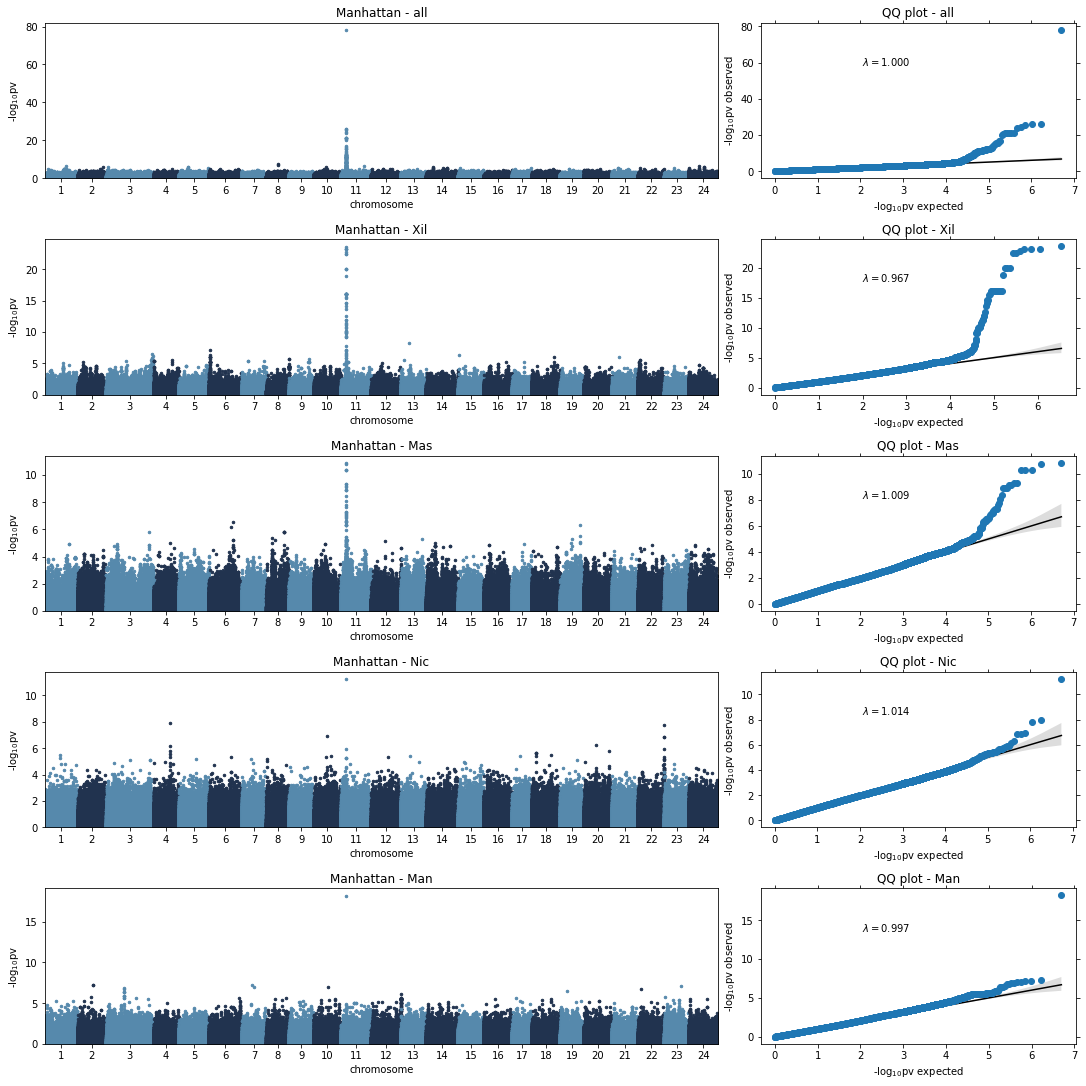

In [342]:
plt.rcParams["figure.figsize"] = (15,15)

manh={}
qq={}

fig = plt.figure()

manh['all'] = plt.subplot2grid((5, 3), (0, 0), colspan=2)
qq['all'] = plt.subplot2grid((5, 3), (0, 2))
manh['Xil'] = plt.subplot2grid((5, 3), (1, 0), colspan=2)
qq['Xil'] = plt.subplot2grid((5, 3), (1, 2))
manh['Mas'] = plt.subplot2grid((5, 3), (2, 0), colspan=2)
qq['Mas'] = plt.subplot2grid((5, 3), (2, 2))
manh['Nic'] = plt.subplot2grid((5, 3), (3, 0), colspan=2)
qq['Nic'] = plt.subplot2grid((5, 3), (3, 2))
manh['Man'] = plt.subplot2grid((5, 3), (4, 0), colspan=2)
qq['Man'] = plt.subplot2grid((5, 3), (4, 2))

for subset in ['all','Xil','Nic','Man','Mas']:
    
    limix.plot.manhattan(unilmm_dat_plot[subset], ax=manh[subset], pts_kws={'markersize':5})
    limix.plot.qqplot(unilmm_dat_plot[subset][['pv']], ax=qq[subset])
    manh[subset].title.set_text("Manhattan - " + subset)
    qq[subset].title.set_text("QQ plot - " + subset)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)